#### Imports 

In [1]:
from matplotlib import pyplot as plt


plt.rcParams['figure.figsize'] = (20, 10)

In [2]:
import bbox_visualizer as bbv
import logging
import boto3
import json
import cv2
import os

##### Setup logger

In [3]:
logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

#### Explore test images 

Test image: 5.png


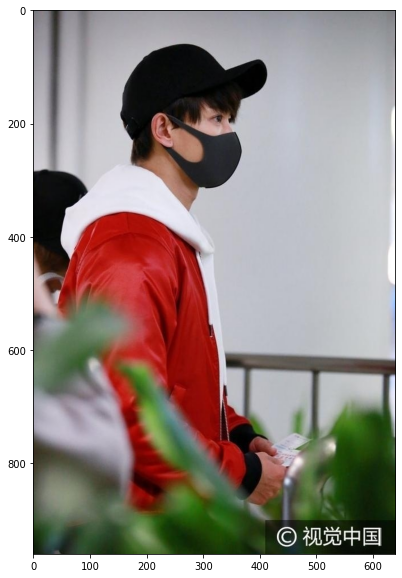

Test image: 1.png


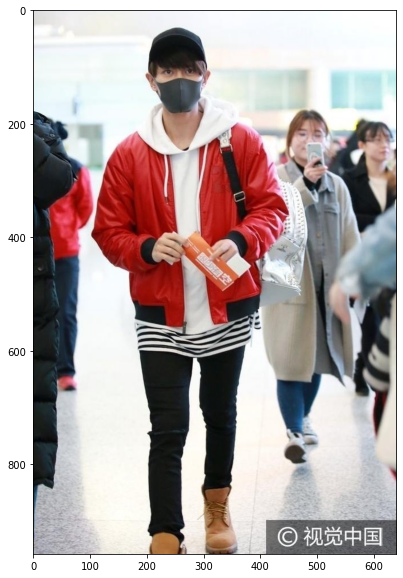

Test image: 3.png


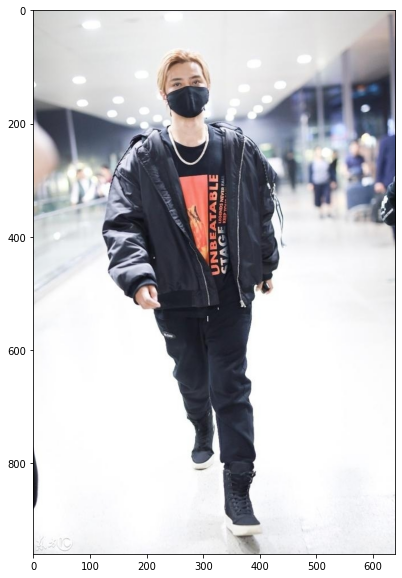

Test image: 2.png


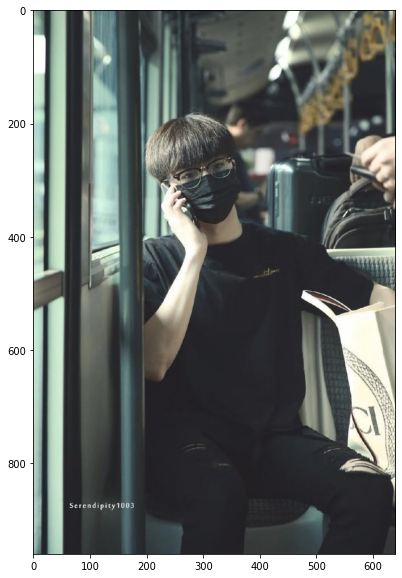

Test image: 4.png


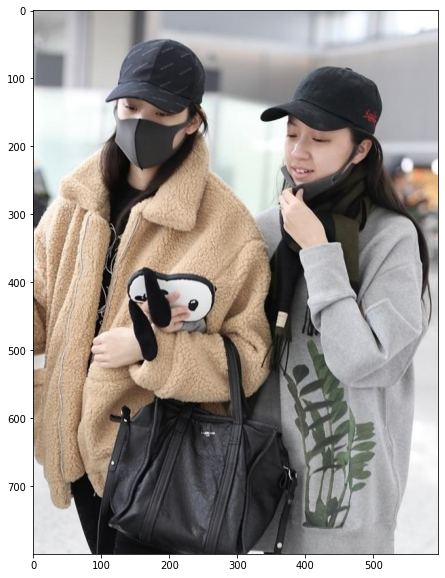

In [4]:
for root, _, files in os.walk('./test'):
    for file_ in files:
        image_path = f'{root}/{file_}'
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        logger.info(f'Test image: {file_}')
        plt.imshow(image)
        plt.show()

#### Invoke SageMaker endpoint for inference (Mask detection)

In [5]:
def invoke_endpoint(image):
    # Replace endpoint_name below with the one you create
    endpoint_name = 'jumpstart-ftc-mx-od-ssd-512-mobilenet1-0-coco-1'
    sagemaker = boto3.client('runtime.sagemaker')
    response = sagemaker.invoke_endpoint(EndpointName=endpoint_name, 
                                         ContentType='application/x-image', 
                                         Body=image)
    predictions = json.loads(response['Body'].read())
    return predictions

In [6]:
def filter_bboxes_with_high_confidence(bboxes, confidences):
    filtered_bboxes = []
    for i, bbox in enumerate(bboxes):
        if confidences[i] > 0.99:
            filtered_bboxes.append(bbox)
    return filtered_bboxes

In [7]:
def normalize(bboxes, image):
    normalized_bboxes = []
    for bbox in bboxes:
        x, y, w, h = bbox
        dh, dw, _ = image.shape
        l = int((x - w / 2) * dw)
        r = int((x + w / 2) * dw)
        t = int((y - h / 2) * dh)
        b = int((y + h / 2) * dh)

        if l < 0:
            l = 0
            
        if r > dw - 1:
            r = dw - 1
            
        if t < 0:
            t = 0
            
        if b > dh - 1:
            b = dh - 1
            
        x1, x2, y1, y2 = l, r, t, b
        normalized_bboxes.append([x1, y1, x2, y2])
    return normalized_bboxes

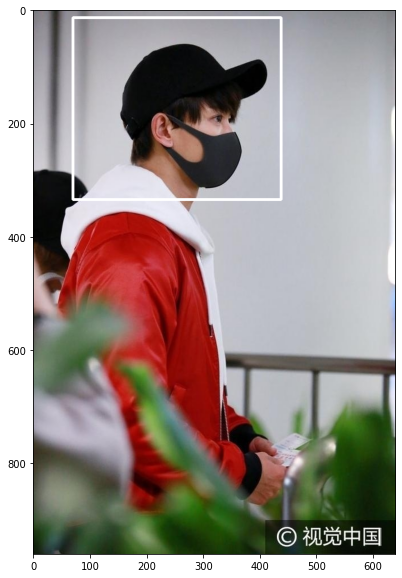

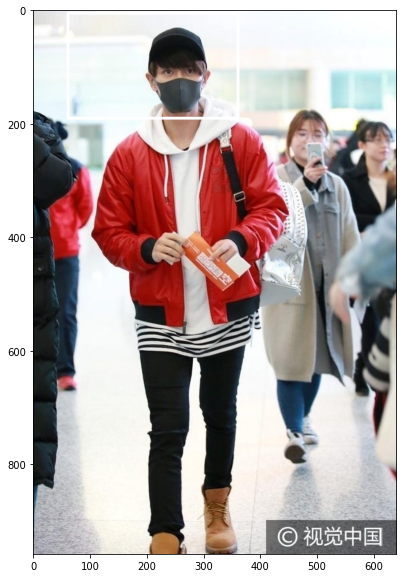

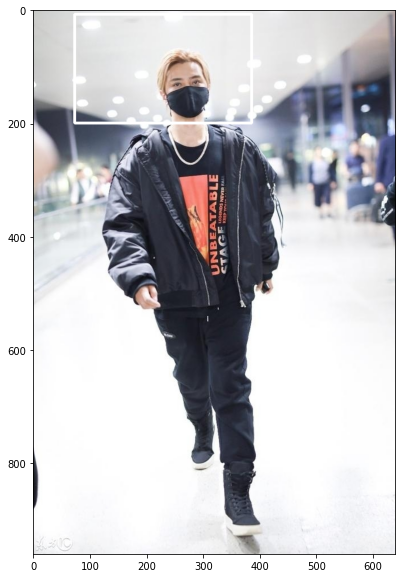

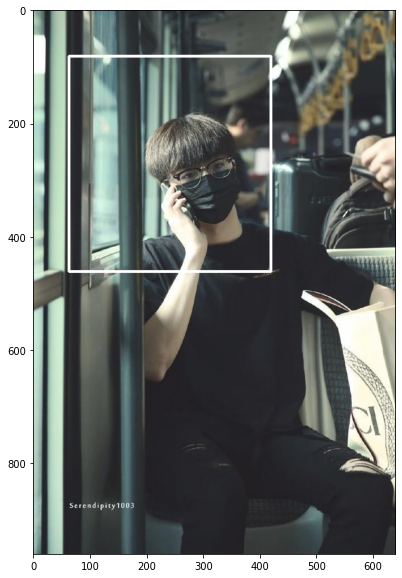

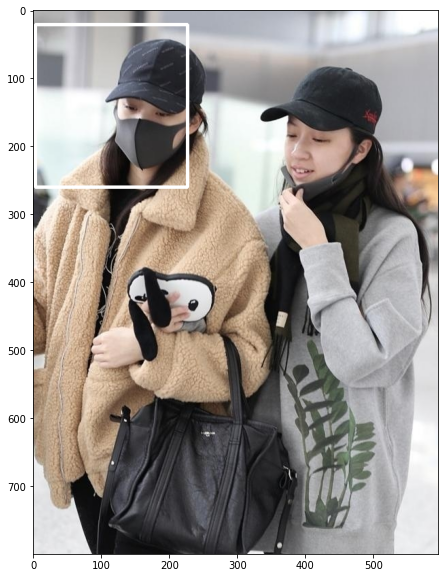

In [8]:
for root, _, files in os.walk('./test'):
    for file_ in files:
        image_path = f'{root}/{file_}'
        with open(image_path, 'rb') as file_:
            image_bytes = file_.read()
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            predictions = invoke_endpoint(image_bytes)  
            bboxes, _, confidences = predictions['normalized_boxes'], predictions['classes'], predictions['scores']
            filtered_bboxes = filter_bboxes_with_high_confidence(bboxes, confidences)
            selected_bboxes = normalize(filtered_bboxes, image)
            image = bbv.draw_multiple_rectangles(image, selected_bboxes)
            plt.imshow(image)
            plt.show()